In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nona
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

### Add all required libraries

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from nona.nona import nona
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from imblearn.over_sampling import SMOTE
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

### Let’s add 4 features to the dataset to train the model:
* Systolic blood pressure
* Heart rate
*   Breathing rate
*   Temperature

In [ ]:
def process_chartevents(file_path, output_path, item_ids):
    """ collecting features of the dataset

    Keyword arguments:
    file_path -- path to the file
    output_path -- path to the output file
    item_ids -- list of item ids

    """
    item_ids_set = set(item_ids)

    result = {}

    with open(file_path) as f:
        headers = f.readline().replace('\n', '').split(',')
        i = 0
        for line in tqdm(f):
            values = line.replace('\n', '').split(',')
            subject_id = values[0]
            item_id = values[6]
            valuenum = values[8]
            if item_id in item_ids_set:
                if subject_id not in result:
                    result[subject_id] = {}
                result[subject_id][item_id] = valuenum
            i += 1

    table = pd.DataFrame.from_dict(result, orient='index')
    table['subject_id'] = table.index

    table.to_csv(output_path, index=False)

item_ids = [str(x) for x in [225309, 220045, 220210, 223762]]
file_path = './MIMIC/icu/chartevents.csv'
output_path = 'df.csv'

process_chartevents(file_path, output_path, item_ids)

### Let's add a column to the dataset with a target - whether a person has sepsis or not

In [ ]:
def add_diagnosis_column(drgcodes_path, merged_data_path, output_path):
    """Add diagnosis column to dataset.

    Keyword arguments:
    drgcodes_path -- path to the drgcodes file
    merged_data_path -- path to the file with features
    output_path -- path to the output file

    """
    drgcodes = pd.read_csv(drgcodes_path)
    merged_data = pd.read_csv(merged_data_path)

    drgcodes['drg_code'] = pd.to_numeric(drgcodes['drg_code'], errors='coerce')
    merged_data['diagnosis'] = 0

    target_subjects = drgcodes.loc[drgcodes['drg_code'].isin([870, 871, 872]), 'subject_id']
    merged_data.loc[merged_data['subject_id'].isin(target_subjects), 'diagnosis'] = 1

    merged_data.to_csv(output_path, index=False)

drgcodes_path = './MIMIC/hosp/drgcodes.csv'
merged_data_path = './df.csv'
output_path = 'df_with_target.csv'

add_diagnosis_column(drgcodes_path, merged_data_path, output_path)

### There are a lot of gaps in our data, so let's use the NoNa library and fill them in

In [ ]:
def impute_data(input_path, output_path, features):
    """Fill in the blanks.

    Keyword arguments:
    input_path -- path to the input file
    output_path -- path to the output file
    features -- list of features

    """
    df = pd.read_csv(input_path)

    X = df[features]

    nona(
        data=X,
        algreg=make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=0.1)),
        algclass=RandomForestClassifier(max_depth=2, random_state=0)
    )

    df[features] = X

    df.to_csv(output_path, index=False)

input_path = 'df_with_target.csv'
output_path = 'df_with_target_imputed.csv'
features = ['225309', '220045', '220210', '223762']

impute_data(input_path, output_path, features)

### Let's divide the dataset into training and test sets, then balance the training set by target

In [ ]:
def prepare_and_save_data(input_path, test_size, random_state, features, target, resampled_output_path, test_output_path):
    """We divide the data into train and test. Getting rid of class imbalance in train.

    Keyword arguments:
    input_path -- path to the input file
    test_size -- size of the test set
    random_state -- random state
    features -- list of features
    target -- target column

    """
    df = pd.read_csv(input_path)

    train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

    X_train = train_data[features]
    y_train = train_data[target]

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.DataFrame(y_resampled, columns=[target])], axis=1)

    df_resampled.to_csv(resampled_output_path, index=False)
    test_data.to_csv(test_output_path, index=False)

    return df_resampled, test_data

input_path = 'df_with_target_imputed.csv'
test_size = 0.4
random_state = 42
features = ['225309', '220045', '220210', '223762']
target = 'SepsisLabel'
resampled_output_path = 'train_data_MEWS.csv'
test_output_path = 'test_data.csv'

df_resampled, test_data = prepare_and_save_data(input_path, test_size, random_state, features, target, resampled_output_path, test_output_path)

Let's make sure that the classes in the training data are balanced

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/train_data_MEWS.csv')

In [7]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

27249
27249


### Let's divide the test dataset into test and validation ones, then balance the samples

In [ ]:
def resample_test_val_data(input_path, test_size, random_state, features, target, test_output_path, val_output_path):
    """We divide the data into test and validation. Getting rid of class imbalance in test and in validation.

    Keyword arguments:
    input_path -- path to the input file
    test_size -- size of the test set
    random_state -- random state
    features -- list of features
    target -- target column

    """
    df = pd.read_csv(input_path)
    data = df.drop(['subject_id'], axis=1)
    test_data, val_data = train_test_split(data, test_size=test_size, random_state=random_state)

    smote1 = SMOTE(random_state=42)
    X1 = test_data[features]
    y1 = test_data[target]
    X_resampled1, y_resampled1 = smote1.fit_resample(X1, y1)
    df_resampled1 = pd.concat([pd.DataFrame(X_resampled1, columns=features), pd.DataFrame(y_resampled1, columns=[target])], axis=1)
    df_resampled1.to_csv(test_output_path, index=False)

    smote2 = SMOTE(random_state=42)
    X2 = val_data[features]
    y2 = val_data[target]
    X_resampled2, y_resampled2 = smote2.fit_resample(X2, y2)
    df_resampled2 = pd.concat([pd.DataFrame(X_resampled2, columns=features), pd.DataFrame(y_resampled2, columns=[target])], axis=1)
    df_resampled2.to_csv(val_output_path, index=False)

input_path = 'test_data_31.csv'
test_size = 0.4
random_state = 42
features = ['225309', '220045', '220210', '223762']
target = 'diagnosis'
test_output_path = 'test_resampled_data.csv'
val_output_path = 'val_resampled_data.csv'
resample_test_val_data(input_path, test_size, random_state, features, target, test_output_path, val_output_path)

Making sure the classes are balanced

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/val_resampled_data_MEWS.csv')

In [9]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

9128
9128


In [10]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/test_resampled_data_MEWS.csv')

In [11]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

9065
9065


### Let's use the TabNet transformer as a learning model. Let's train the model with selected hyperparameters, preserve the importance of the features and the model itself

In [33]:
def train_tabnet_model(train_path, val_path, feature_importances_path, model_save_path, optimizer_params, scheduler_params, pretraining_lr=0.05, training_lr=0.05, mask_type='sparsemax', pretraining_ratio=1.0, max_epochs=200, patience=50):
    """Model training, preserving the importance of features and saving the model.

    Keyword arguments:
    train_path -- path to the train data
    val_path -- path to the validation data
    feature_importances_path -- path to the file with feature importances
    model_save_path -- path to the model
    optimizer_params -- optimizer parameters
    scheduler_params -- scheduler parameters
    pretraining_lr -- learning rate for pretraining (default 0.05)
    training_lr -- learning rate for training (default 0.05)
    mask_type -- mask type (default 'sparsemax')
    pretraining_ratio -- ratio of pretraining data (default 1.0)
    max_epochs -- maximum number of epochs (default 200)
    patience -- patience (default 50)

    """
    train_data = pd.read_csv(train_path)
    val_data = pd.read_csv(val_path)

    X_train = train_data.drop(['diagnosis'], axis=1)
    y_train = train_data['diagnosis']

    X_val = val_data.drop(['diagnosis'], axis=1)
    y_val = val_data['diagnosis']

    unsupervised_model = TabNetPretrainer(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=pretraining_lr),
        mask_type=mask_type
    )

    unsupervised_model.fit(
        X_train=X_train.values,
        eval_set=[X_val.values],
        pretraining_ratio=pretraining_ratio,
    )

    clf = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=training_lr),
        scheduler_params=scheduler_params,
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type=mask_type
    )

    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_val.values, y_val.values)],
        eval_metric=['auc'],
        max_epochs=max_epochs,
        patience=patience,
        from_unsupervised=unsupervised_model
    )

    with open(feature_importances_path, 'w') as f:
        f.write(f'{clf.feature_importances_}')

    clf.save_model(model_save_path)

train_path = '/content/drive/MyDrive/Лаба ML/transformers/train_data_MEWS.csv'
val_path = '/content/drive/MyDrive/Лаба ML/transformers/val_resampled_data_MEWS.csv'
feature_importances_path = 'fimp.txt'
model_save_path = './tabnet_model_test_1'
optimizer_params = dict(lr=0.05)
scheduler_params = {
    "step_size": 10,
    "gamma": 0.9
}

train_tabnet_model(train_path, val_path, feature_importances_path, model_save_path, optimizer_params, scheduler_params)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 36.84088| val_0_unsup_loss_numpy: 3.5068378504386677e+28|  0:00:05s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/metrics.py:59: RuntimeWarning: overflow encountered in square
  reconstruction_errors = np.multiply(errors, obf_vars) ** 2
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


epoch 1  | loss: 1.14778 | val_0_unsup_loss_numpy: inf     |  0:00:09s
epoch 2  | loss: 1.02261 | val_0_unsup_loss_numpy: inf     |  0:00:12s
epoch 3  | loss: 1.02943 | val_0_unsup_loss_numpy: inf     |  0:00:16s
epoch 4  | loss: 1.00712 | val_0_unsup_loss_numpy: inf     |  0:00:21s
epoch 5  | loss: 1.00862 | val_0_unsup_loss_numpy: inf     |  0:00:24s
epoch 6  | loss: 1.01511 | val_0_unsup_loss_numpy: inf     |  0:00:27s
epoch 7  | loss: 1.00804 | val_0_unsup_loss_numpy: inf     |  0:00:32s
epoch 8  | loss: 1.00626 | val_0_unsup_loss_numpy: inf     |  0:00:36s
epoch 9  | loss: 1.01127 | val_0_unsup_loss_numpy: inf     |  0:00:39s
epoch 10 | loss: 1.00864 | val_0_unsup_loss_numpy: inf     |  0:00:43s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 3.5068378504386677e+28


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.68376 | val_0_auc: 0.44233 |  0:00:04s
epoch 1  | loss: 0.66186 | val_0_auc: 0.51559 |  0:00:09s
epoch 2  | loss: 0.66131 | val_0_auc: 0.58031 |  0:00:12s
epoch 3  | loss: 0.65913 | val_0_auc: 0.58202 |  0:00:15s
epoch 4  | loss: 0.65881 | val_0_auc: 0.59011 |  0:00:18s
epoch 5  | loss: 0.65877 | val_0_auc: 0.59297 |  0:00:23s
epoch 6  | loss: 0.65716 | val_0_auc: 0.58709 |  0:00:26s
epoch 7  | loss: 0.65881 | val_0_auc: 0.58719 |  0:00:29s
epoch 8  | loss: 0.65716 | val_0_auc: 0.59137 |  0:00:32s
epoch 9  | loss: 0.65695 | val_0_auc: 0.59014 |  0:00:36s
epoch 10 | loss: 0.65877 | val_0_auc: 0.58219 |  0:00:40s
epoch 11 | loss: 0.65522 | val_0_auc: 0.58473 |  0:00:43s
epoch 12 | loss: 0.65521 | val_0_auc: 0.57556 |  0:00:46s
epoch 13 | loss: 0.65405 | val_0_auc: 0.56469 |  0:00:49s
epoch 14 | loss: 0.65396 | val_0_auc: 0.57425 |  0:00:54s
epoch 15 | loss: 0.65388 | val_0_auc: 0.58365 |  0:00:57s
epoch 16 | loss: 0.65396 | val_0_auc: 0.5815  |  0:01:00s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./tabnet_model_test_1.zip


### Let's find out what signs the model paid the most attention to

In [34]:
file_path = '/content/fimp.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

[0.         0.29729455 0.21506934 0.48763611]


### Visualizing the importance of features

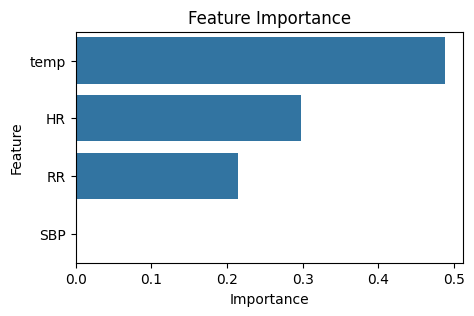

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = [0.0, 0.29729455, 0.21506934, 0.48763611]

importance_df = pd.DataFrame({'Feature': ['SBP','HR','RR','temp'], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Let's look at the metrics obtained as a result of prediction on the test sample

In [36]:
def evaluate_tabnet_model(model_path, test_data_path, metrics_output_path):
    """Evaluate the model.

    Keyword arguments:
    model_path -- path to the model
    test_data_path -- path to the test data
    metrics_output_path -- path to the output file

    """
    loaded_clf = TabNetClassifier()
    loaded_clf.load_model(model_path)

    test_data = pd.read_csv(test_data_path)

    X_test = test_data.drop(['diagnosis'], axis=1)
    y_test = test_data['diagnosis']

    result = loaded_clf.predict(X_test.values)

    accuracy = (result == y_test.values).mean()
    precision = precision_score(y_test.values, result)
    recall = recall_score(y_test.values, result)
    f1 = f1_score(y_test.values, result)

    with open(metrics_output_path, 'w') as file:
        file.write(f'Accuracy: {accuracy}\n')
        file.write(f'Precision: {precision}\n')
        file.write(f'Recall: {recall}\n')
        file.write(f'F1-score: {f1}\n')
        file.close()

model_path = "./tabnet_model_test_1.zip"
test_data_path = '/content/drive/MyDrive/Лаба ML/transformers/test_resampled_data_MEWS.csv'
metrics_output_path = "metrics.txt"

evaluate_tabnet_model(model_path, test_data_path, metrics_output_path)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [37]:
file_path = '/content/metrics.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

Accuracy: 0.5257584114726972
Precision: 0.5143842789379659
Recall: 0.9211252068394925
F1-score: 0.660131235670804

